# 🔍 YOLO를 활용한 실시간 객체 탐지

## 🎯 학습 목표
- **YOLO(You Only Look Once)**  이해
- **실시간 객체 탐지** 시스템 구현
- **컴퓨터 비전**의 실무 활용 경험
- **개인 이미지**를 활용한 맞춤형 프로젝트

## 💡 YOLO란?
**YOLO(You Only Look Once)**는 이미지를 보고 객체를 탐지하는 Object Detection 알고리즘입니다.

![image](https://raw.githubusercontent.com/simsimee/HKNU_lecture/refs/heads/main/%E1%84%83%E1%85%A6%E1%84%8B%E1%85%B5%E1%84%90%E1%85%A5/ex.jpeg)

![image](https://raw.githubusercontent.com/simsimee/HKNU_lecture/refs/heads/main/%E1%84%83%E1%85%A6%E1%84%8B%E1%85%B5%E1%84%90%E1%85%A5/eee.jpeg)
### 🌟 YOLO의 특징
- **빠른 속도**: 실시간 처리 가능 (30+ FPS) (Frame per Second) --> 맥북 프로는 120
- **높은 정확도**: 최신 딥러닝 기술 적용
- **쉬운 사용**: 사전 훈련된 모델 제공

----
## 🔧 환경 설정 및 라이브러리 설치

### 📦 필요한 라이브러리
- **ultralytics**: YOLO 최신 버전 (YOLOv8)
- **opencv-python**: 이미지/비디오 처리
- **pillow**: 이미지 편집
- **matplotlib**: 결과 시각화
- **torch**: 딥러닝 프레임워크

In [1]:
# ultralytics 설치 (YOLOv8 포함) – 약 1분
!pip install ultralytics>=8.0.0 ipywidgets matplotlib seaborn

In [2]:
import ultralytics
from ultralytics import YOLO
import torch, os, matplotlib.pyplot as plt, seaborn as sns, pandas as pd
print('Ultralytics version:', ultralytics.__version__)
print('PyTorch version    :', torch.__version__)
print('CUDA available     :', torch.cuda.is_available())
device = 0 if torch.cuda.is_available() else 'cpu'

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics version: 8.3.162
PyTorch version    : 2.6.0+cu124
CUDA available     : True



## 2. 데이터셋 – COCO128  📊

- **COCO128**은 COCO 2017 train split 중 앞 128장을 뽑은 소규모 튜토리얼용 데이터셋
- 자동으로 다운로드·전처리


In [3]:
# ⬇️ coco128 데이터셋 다운로드 (ZIP 방식, 울트라리틱스 함수 불필요)
import urllib.request, zipfile, os, pathlib, shutil

url = "https://github.com/ultralytics/yolov5/releases/download/v1.0/coco128.zip"
root = pathlib.Path('datasets')
root.mkdir(parents=True, exist_ok=True)
zip_path = root / 'coco128.zip'

print("Downloading coco128.zip ...")
urllib.request.urlretrieve(url, zip_path)
print("Download complete! Extracting...")

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(root)

zip_path.unlink()  # delete zip file
print("Dataset ready at", root / 'coco128')

Download complete! Extracting...
Dataset ready at datasets/coco128


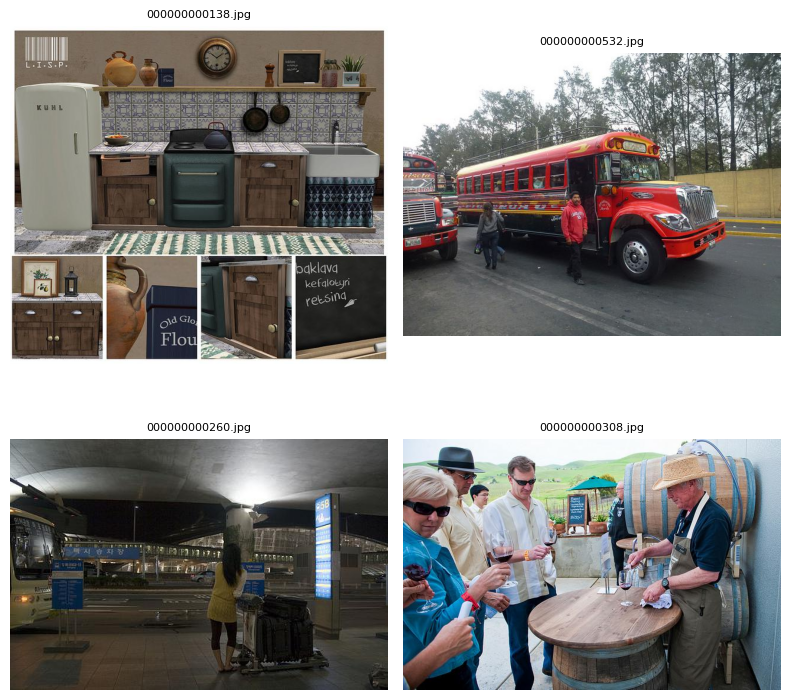

In [4]:
import random, glob, cv2, matplotlib.pyplot as plt

train_imgs = glob.glob('datasets/coco128/images/train2017/*.jpg')
samples = random.sample(train_imgs, 4)

plt.figure(figsize=(8,8))
for i, img_path in enumerate(samples):
    # RGB로 열리는데 OPENCV에서 BGR 순으로 읽어서 이것을 cvtColor로 바꾼다.
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(img_path.split('/')[-1], fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()



## 3. 모델 학습 📚

### mAP (mean Average Precision) 🏆

mAP는 객체 탐지(Object Detection) 모델의 정확도(Precision)와 재현율(Recall)을 종합적으로 평가하는 대표 지표, 하나의 클래스에 대해 IoU(Intersection‑over‑Union) 임계값을 고정한 뒤 Precision–Recall 곡선 아래 넓이(Area Under Curve)를 적분하면 AP(Average Precision) 가 되고, 이를 모든 클래스에 대해 평균 내면 mAP가 됩니다.

#### AP 계산 절차 🎯

1. 예측 박스(Confidence 내림차순)와 GT 박스 매칭
2. IoU ≥ 임계값(예: 0.5)이면 TP, 그렇지 않으면 FP
3. 누적 TP·FP로 Precision, Recall을 계산
4. PR 곡선을 0 → 1까지 101 점(0, 0.01, … 1.0)에서 샘플링해 적분

#### Precision & Recall 계산 🎯

- Precision (정밀도) = TP / (TP + FP)
    - 모델이 '검출했다' 고 예측한 것 중 실제로 맞은 비율 ✅

- Recall (재현율) = TP / (TP + FN)
    - GT(Ground Truth, 정답) 중에서 모델이 놓치지 않고 검출한 비율  🔍

### Confidence & IoU 🎯
- Confidence : 모델이 객체를 얼마나 확신하여 예측했는지를 나타내는 정도 (1에 가까울수록 확신)
- IoU : GT(정답)와 예측한 객체의 Box의 겹치는 영역을 전체 합집합으로 나눈 값 (1에 가까울수록 완전 일치)

### 값 해석하기 ✅

- 1.0 (100 %)에 가까울수록 검출 성능이 좋음 🌟

In [6]:
# ‼️ 에포크 수를 늘릴수록 성능은 좋아지지만 시간이 오래 걸립니다.
model = YOLO('yolov8n.pt')        # nano 모델 (≈3.2 M 파라미터)
results = model.train(
    data='coco128.yaml',          # 내장 데이터셋 경로
    epochs=100,                     # 데모용 5 epoch
    imgsz=640,                      # image size (nxm: padding or 쭈그러트림 등)
    device=device
)

Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=coco128.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=Fa

100%|██████████| 755k/755k [00:00<00:00, 25.7MB/s]


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

 12                  -1  1    148224  ultralytics.nn.modules.block.C2f             [384, 128, 1]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  1     37248  ultralytics.nn.modules.block.C2f             [192, 64, 1]                  
 16                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
 17            [-1, 12]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 18                  -1  1    123648  ultralytics.nn.modules.block.C2f             [192, 128, 1]                 
 19                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

100%|██████████| 5.35M/5.35M [00:00<00:00, 46.4MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 714.8±390.1 MB/s, size: 50.9 KB)


train: Scanning /content/datasets/coco128/labels/train2017... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<00:00, 2319.74it/s]

train: New cache created: /content/datasets/coco128/labels/train2017.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 499.3±103.7 MB/s, size: 52.5 KB)


val: Scanning /content/datasets/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       2.6G      1.156      1.519      1.226        172        640: 100%|██████████| 8/8 [00:03<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

                   all        128        929      0.649      0.536      0.613      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.53G      1.208      1.435      1.242        231        640: 100%|██████████| 8/8 [00:02<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]

                   all        128        929      0.649      0.559       0.63      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.56G      1.159      1.364      1.251        192        640: 100%|██████████| 8/8 [00:01<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]

                   all        128        929      0.647      0.591      0.647      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.56G      1.165      1.307      1.227        215        640: 100%|██████████| 8/8 [00:01<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.92it/s]

                   all        128        929      0.666      0.585       0.66      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.56G      1.184      1.305      1.259        236        640: 100%|██████████| 8/8 [00:01<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]

                   all        128        929       0.67      0.616      0.677      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.56G      1.179      1.279      1.227        253        640: 100%|██████████| 8/8 [00:02<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.54it/s]

                   all        128        929      0.685      0.624       0.69      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.57G      1.077      1.195      1.189        282        640: 100%|██████████| 8/8 [00:01<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]

                   all        128        929      0.698      0.645      0.696      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.57G      1.121        1.2      1.203        192        640: 100%|██████████| 8/8 [00:01<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]

                   all        128        929      0.696       0.66      0.716      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.57G      1.098      1.102      1.183        180        640: 100%|██████████| 8/8 [00:01<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]

                   all        128        929      0.709       0.66      0.722      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.57G      1.059      1.107       1.15        180        640: 100%|██████████| 8/8 [00:02<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.35it/s]

                   all        128        929      0.712      0.663      0.727       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.57G      1.069      1.089       1.17        263        640: 100%|██████████| 8/8 [00:01<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]

                   all        128        929      0.746       0.66      0.741      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.57G       1.09      1.118      1.174        176        640: 100%|██████████| 8/8 [00:01<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  4.00it/s]

                   all        128        929      0.773      0.657       0.75      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.58G      1.088      1.065      1.178        251        640: 100%|██████████| 8/8 [00:01<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

                   all        128        929        0.8      0.663      0.773      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.59G      1.026      1.021      1.151        208        640: 100%|██████████| 8/8 [00:02<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]

                   all        128        929      0.768      0.718      0.787      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.59G      1.032      1.016      1.137        251        640: 100%|██████████| 8/8 [00:01<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.60it/s]

                   all        128        929      0.808      0.714      0.792      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.59G      1.082      1.044      1.158        189        640: 100%|██████████| 8/8 [00:01<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]

                   all        128        929      0.813      0.724      0.799      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.61G      1.038      1.038      1.152        184        640: 100%|██████████| 8/8 [00:02<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

                   all        128        929      0.786      0.756      0.804       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.61G      1.025     0.9828      1.123        208        640: 100%|██████████| 8/8 [00:01<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]

                   all        128        929      0.807       0.75      0.808      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.63G      1.038     0.9637      1.133        169        640: 100%|██████████| 8/8 [00:01<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all        128        929      0.822      0.747      0.817       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.63G     0.9977     0.9487      1.128        185        640: 100%|██████████| 8/8 [00:01<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]

                   all        128        929      0.833      0.751      0.814       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.63G     0.9785     0.9106      1.106        317        640: 100%|██████████| 8/8 [00:02<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.00it/s]

                   all        128        929      0.843      0.745      0.816      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.63G     0.9533     0.9151      1.093        255        640: 100%|██████████| 8/8 [00:01<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.02it/s]

                   all        128        929      0.825       0.75      0.815      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.63G      1.006     0.9568      1.113        227        640: 100%|██████████| 8/8 [00:01<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.93it/s]

                   all        128        929      0.812      0.766      0.822      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.65G     0.9365      0.904      1.104        196        640: 100%|██████████| 8/8 [00:01<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]

                   all        128        929      0.847      0.742      0.826      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.65G     0.9519     0.8932      1.095        244        640: 100%|██████████| 8/8 [00:01<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]

                   all        128        929      0.832      0.743      0.827      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.65G      0.998     0.8959      1.116        228        640: 100%|██████████| 8/8 [00:01<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.73it/s]

                   all        128        929      0.855      0.743      0.833      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.65G     0.9603     0.8642      1.098        202        640: 100%|██████████| 8/8 [00:01<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all        128        929       0.86      0.743      0.834      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.65G     0.9541     0.8749      1.115        229        640: 100%|██████████| 8/8 [00:02<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        128        929      0.834      0.767      0.836      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.65G     0.9461     0.8836      1.104        169        640: 100%|██████████| 8/8 [00:01<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.92it/s]

                   all        128        929      0.859      0.767      0.841      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.65G     0.9468     0.8253      1.088        201        640: 100%|██████████| 8/8 [00:02<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all        128        929      0.854      0.769       0.85      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.65G     0.9413     0.8607      1.113        180        640: 100%|██████████| 8/8 [00:02<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.63it/s]

                   all        128        929      0.859      0.764      0.851      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.65G     0.9242     0.8374      1.093        232        640: 100%|██████████| 8/8 [00:01<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.96it/s]

                   all        128        929      0.843      0.772      0.852      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.65G     0.9501     0.8545      1.089        184        640: 100%|██████████| 8/8 [00:01<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all        128        929      0.854      0.776      0.851      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.65G     0.9956     0.9178      1.111        250        640: 100%|██████████| 8/8 [00:01<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]

                   all        128        929      0.829      0.796      0.855       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.65G     0.9021     0.8435      1.086        141        640: 100%|██████████| 8/8 [00:02<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]

                   all        128        929      0.832      0.803      0.857      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.65G     0.9243     0.8582      1.076        253        640: 100%|██████████| 8/8 [00:01<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]

                   all        128        929      0.832      0.802      0.859      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.65G       0.95     0.8605      1.078        242        640: 100%|██████████| 8/8 [00:01<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]

                   all        128        929      0.832       0.81      0.859      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.65G     0.9187     0.8011      1.085        162        640: 100%|██████████| 8/8 [00:01<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

                   all        128        929       0.85      0.798      0.858       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.65G     0.9186     0.8359      1.079        283        640: 100%|██████████| 8/8 [00:02<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]

                   all        128        929      0.845      0.802      0.861      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.65G     0.8888     0.7889       1.07        166        640: 100%|██████████| 8/8 [00:01<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]

                   all        128        929      0.874      0.791      0.865      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.65G     0.8746     0.7864      1.052        190        640: 100%|██████████| 8/8 [00:01<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  4.00it/s]

                   all        128        929      0.877      0.787      0.865      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.65G     0.9309     0.7994      1.073        219        640: 100%|██████████| 8/8 [00:02<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]

                   all        128        929      0.883      0.788      0.865      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.65G     0.9055     0.7844      1.075        273        640: 100%|██████████| 8/8 [00:01<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]

                   all        128        929      0.882      0.784      0.868        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.65G     0.9075     0.8075      1.073        248        640: 100%|██████████| 8/8 [00:01<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.98it/s]

                   all        128        929      0.884      0.785       0.87      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.65G     0.9221     0.8015      1.064        216        640: 100%|██████████| 8/8 [00:01<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.91it/s]

                   all        128        929      0.896      0.772      0.866        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.65G      0.928      0.828      1.073        193        640: 100%|██████████| 8/8 [00:02<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        128        929      0.899      0.769      0.871      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.65G     0.9706     0.8692      1.078        229        640: 100%|██████████| 8/8 [00:01<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.91it/s]

                   all        128        929      0.893      0.769       0.87      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.65G     0.8732     0.7511      1.066        218        640: 100%|██████████| 8/8 [00:01<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.89it/s]

                   all        128        929        0.9      0.765      0.872      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.65G     0.9093     0.7788      1.064        200        640: 100%|██████████| 8/8 [00:01<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.29it/s]

                   all        128        929      0.892       0.77      0.873      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.65G     0.8262     0.7354      1.027        170        640: 100%|██████████| 8/8 [00:02<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]

                   all        128        929      0.894      0.772      0.872      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.65G     0.8933      0.764      1.058        264        640: 100%|██████████| 8/8 [00:01<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]

                   all        128        929       0.89      0.781      0.877       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.65G     0.8658     0.7729      1.071        222        640: 100%|██████████| 8/8 [00:02<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]

                   all        128        929      0.871      0.799      0.875      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.65G     0.8849     0.7586      1.066        236        640: 100%|██████████| 8/8 [00:02<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.63it/s]

                   all        128        929      0.866      0.811      0.875      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.65G     0.8835      0.769      1.055        196        640: 100%|██████████| 8/8 [00:01<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.90it/s]

                   all        128        929      0.898      0.791      0.875       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.65G      0.875     0.7387       1.05        196        640: 100%|██████████| 8/8 [00:01<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.96it/s]

                   all        128        929      0.885      0.794      0.876      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.65G     0.8559     0.7137      1.032        213        640: 100%|██████████| 8/8 [00:01<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.89it/s]

                   all        128        929      0.859      0.802      0.875      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.65G     0.8589     0.7288      1.046        186        640: 100%|██████████| 8/8 [00:02<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]

                   all        128        929       0.85      0.815      0.875       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.65G     0.8904     0.7603      1.041        227        640: 100%|██████████| 8/8 [00:01<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.94it/s]

                   all        128        929      0.842       0.82      0.875      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.65G     0.8487     0.7343      1.039        287        640: 100%|██████████| 8/8 [00:01<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all        128        929      0.848      0.828      0.879      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.65G     0.8935     0.7496      1.067        195        640: 100%|██████████| 8/8 [00:01<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]

                   all        128        929      0.845      0.834      0.881      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.65G      0.885      0.761      1.063        191        640: 100%|██████████| 8/8 [00:02<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.57it/s]

                   all        128        929      0.827      0.844      0.879      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.65G     0.8376      0.752      1.057        186        640: 100%|██████████| 8/8 [00:01<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all        128        929      0.824       0.85      0.882      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.66G     0.8688     0.7417       1.03        185        640: 100%|██████████| 8/8 [00:01<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.95it/s]

                   all        128        929      0.893       0.81      0.884      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.66G     0.8538     0.7569      1.037        232        640: 100%|██████████| 8/8 [00:01<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]

                   all        128        929      0.895      0.807      0.884      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.66G     0.8376     0.7349       1.04        184        640: 100%|██████████| 8/8 [00:01<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]

                   all        128        929      0.893      0.807      0.884      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.66G     0.8521     0.7236      1.044        173        640: 100%|██████████| 8/8 [00:01<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]

                   all        128        929      0.846      0.834      0.884      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.66G     0.8215     0.7089      1.049        252        640: 100%|██████████| 8/8 [00:01<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.89it/s]

                   all        128        929      0.841      0.846      0.882      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.66G     0.8617     0.7367      1.045        171        640: 100%|██████████| 8/8 [00:02<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        128        929      0.867      0.838      0.885       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.66G     0.8457     0.6884      1.043        200        640: 100%|██████████| 8/8 [00:01<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]

                   all        128        929       0.89      0.827      0.887      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.66G       0.83     0.6907      1.028        244        640: 100%|██████████| 8/8 [00:01<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.97it/s]

                   all        128        929      0.904      0.812      0.887       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.66G     0.9099       0.76      1.055        272        640: 100%|██████████| 8/8 [00:01<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.73it/s]

                   all        128        929      0.906       0.81      0.886      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.66G     0.8527     0.7246      1.047        206        640: 100%|██████████| 8/8 [00:02<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]

                   all        128        929      0.914      0.808      0.886      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.66G     0.8395     0.7328      1.052        237        640: 100%|██████████| 8/8 [00:01<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  4.00it/s]

                   all        128        929      0.917      0.807      0.885      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.66G     0.8253     0.7098      1.038        175        640: 100%|██████████| 8/8 [00:01<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.58it/s]

                   all        128        929      0.915      0.809      0.887      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.66G     0.8824     0.7471      1.039        277        640: 100%|██████████| 8/8 [00:01<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.60it/s]

                   all        128        929      0.925      0.805      0.887      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.66G     0.8131     0.7097      1.037        241        640: 100%|██████████| 8/8 [00:02<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]

                   all        128        929      0.915      0.813      0.887      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.66G     0.8177     0.6845      1.035        233        640: 100%|██████████| 8/8 [00:01<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.95it/s]

                   all        128        929      0.917      0.812      0.887      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.66G     0.8504     0.7133      1.037        171        640: 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.92it/s]

                   all        128        929      0.909      0.817      0.886      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.66G     0.8268     0.7037      1.031        144        640: 100%|██████████| 8/8 [00:01<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.98it/s]

                   all        128        929      0.907      0.815      0.887      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.66G     0.7783      0.691      1.027        170        640: 100%|██████████| 8/8 [00:02<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.72it/s]

                   all        128        929      0.912      0.815      0.888      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.66G     0.8564     0.7052      1.023        192        640: 100%|██████████| 8/8 [00:01<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  4.00it/s]

                   all        128        929      0.908      0.814      0.888      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.66G     0.7782     0.6749      1.017        166        640: 100%|██████████| 8/8 [00:01<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.89it/s]

                   all        128        929      0.907      0.812      0.886      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.66G     0.8256     0.6992      1.022        164        640: 100%|██████████| 8/8 [00:02<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]

                   all        128        929      0.908       0.81      0.886      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.66G     0.8507      0.695      1.029        204        640: 100%|██████████| 8/8 [00:01<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.99it/s]

                   all        128        929      0.911      0.808      0.887       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.66G     0.8572     0.7221      1.044        244        640: 100%|██████████| 8/8 [00:01<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]

                   all        128        929      0.914      0.806      0.887      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.66G     0.8673     0.7412      1.046        174        640: 100%|██████████| 8/8 [00:01<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        128        929      0.914      0.814      0.889      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.66G     0.8239     0.6932      1.027        144        640: 100%|██████████| 8/8 [00:02<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]

                   all        128        929      0.912      0.817      0.889      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.66G     0.8216     0.6819      1.024        182        640: 100%|██████████| 8/8 [00:01<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.98it/s]

                   all        128        929      0.901      0.827       0.89      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.66G     0.8075     0.6871     0.9963        227        640: 100%|██████████| 8/8 [00:01<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.91it/s]

                   all        128        929      0.902      0.826      0.889       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      3.66G     0.8258      0.712      1.039        182        640: 100%|██████████| 8/8 [00:01<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.60it/s]

                   all        128        929      0.906      0.825      0.892       0.74


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      3.66G     0.8934     0.7602      1.034        100        640: 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]

                   all        128        929      0.902      0.822      0.887      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      3.66G     0.8485     0.7857      1.006        169        640: 100%|██████████| 8/8 [00:01<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]

                   all        128        929      0.916      0.811      0.885      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      3.66G     0.8384     0.7574      1.008        128        640: 100%|██████████| 8/8 [00:01<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]

                   all        128        929      0.915      0.805      0.884      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      3.66G     0.8746     0.7472      1.015        119        640: 100%|██████████| 8/8 [00:02<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]

                   all        128        929      0.887      0.816      0.882      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      3.66G     0.8567      0.725      1.032        126        640: 100%|██████████| 8/8 [00:01<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.95it/s]

                   all        128        929      0.883      0.815       0.88      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      3.66G     0.8659     0.7179      1.018        126        640: 100%|██████████| 8/8 [00:01<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]

                   all        128        929      0.884      0.815      0.879       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      3.66G     0.8235     0.6658      1.008        120        640: 100%|██████████| 8/8 [00:01<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all        128        929      0.883      0.818      0.879      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      3.66G     0.8399     0.6921     0.9834         98        640: 100%|██████████| 8/8 [00:02<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]

                   all        128        929      0.884      0.814      0.878      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      3.66G     0.8413     0.7102     0.9968        129        640: 100%|██████████| 8/8 [00:01<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.92it/s]

                   all        128        929      0.887      0.815      0.878      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      3.66G     0.8663     0.7335      1.019         71        640: 100%|██████████| 8/8 [00:01<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.98it/s]

                   all        128        929      0.886      0.814      0.877      0.714



100 epochs completed in 0.098 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.5MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.5MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


                   all        128        929      0.899      0.827      0.889       0.74
                person         61        254      0.985       0.74      0.885      0.703
               bicycle          3          6       0.92        0.5      0.615      0.495
                   car         12         46      0.842      0.349      0.582      0.336
            motorcycle          4          5      0.955          1      0.995      0.968
              airplane          5          6      0.945          1      0.995      0.942
                   bus          5          7          1      0.782      0.978      0.815
                 train          3          3       0.91          1      0.995      0.808
                 truck          5         12      0.913        0.5      0.611      0.486
                  boat          2          6          1      0.602      0.873      0.673
         traffic light          4         14          1      0.326      0.423      0.263
             stop sig

## 4. 예측 결과 시각화 📚


Found https://ultralytics.com/images/bus.jpg locally at bus.jpg
image 1/1 /content/bus.jpg: 640x480 3 persons, 1 bus, 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)


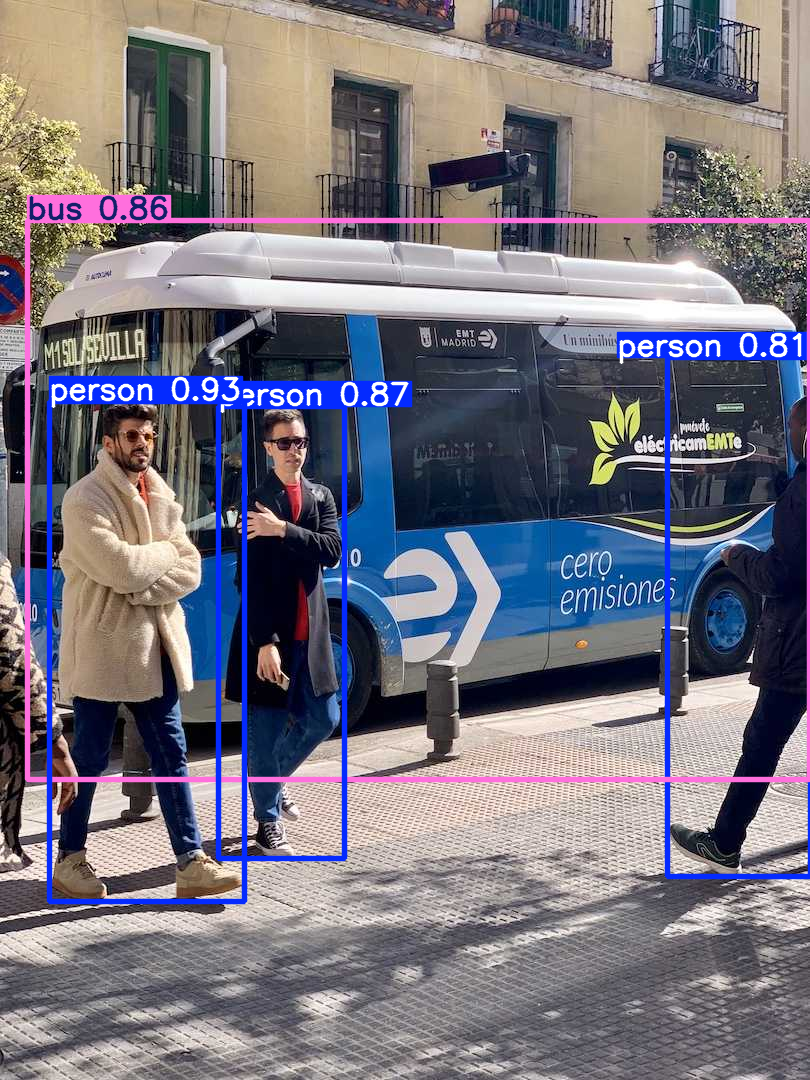

In [9]:
from PIL import Image

sample_img = 'https://ultralytics.com/images/bus.jpg'  # 예제 이미지
pred = model.predict(sample_img, save=False, imgsz=640, conf=0.50) # conf: confidence
res = pred[0]

#시각화
img_bgr = res.plot(boxes=True, masks=True, probs=False, labels=True)
img_rgb = Image.fromarray(img_bgr[..., ::-1])
display(img_rgb)

## 5. 학습 곡선 분석 📈

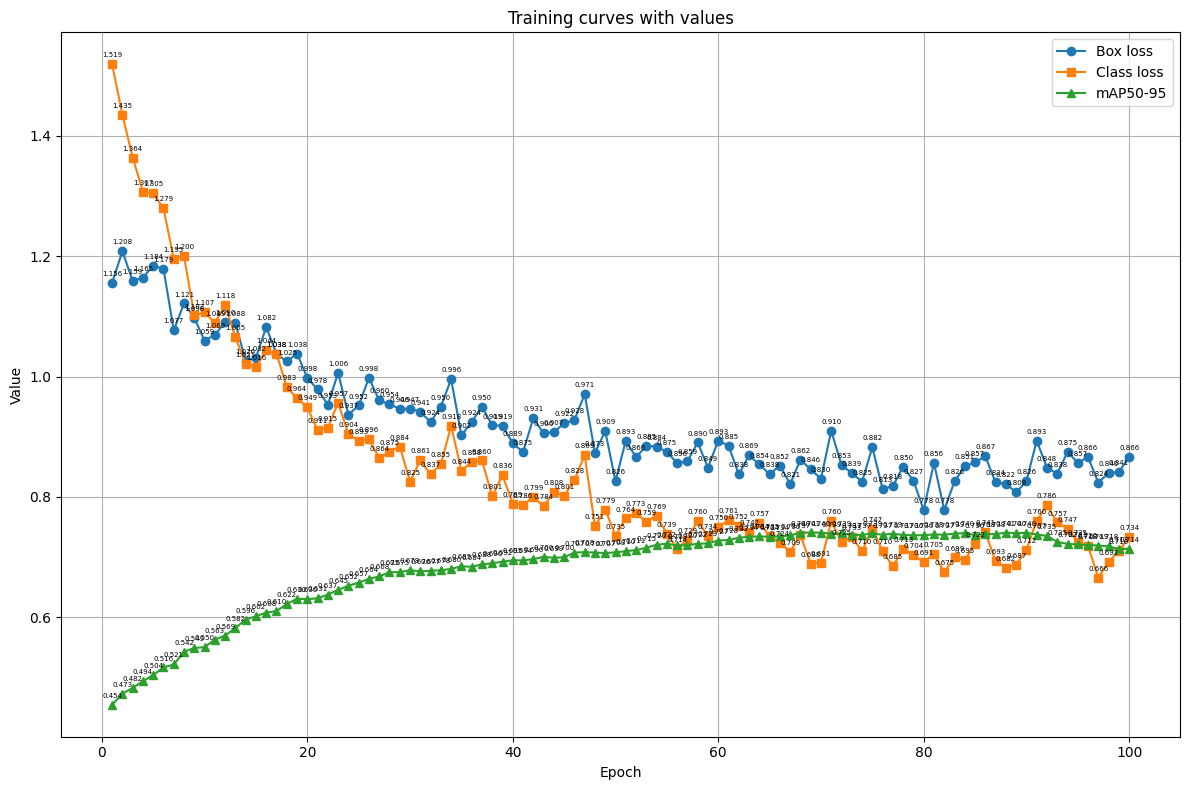

In [13]:
logfile = 'runs/detect/train2/results.csv'
df = pd.read_csv(logfile)

plt.figure(figsize=(12,8))
# 플롯
plt.plot(df['epoch'], df['train/box_loss'], marker='o', label='Box loss')       # 좌표 label에 대한
plt.plot(df['epoch'], df['train/cls_loss'], marker='s', label='Class loss')     # 클래스 label에 대한
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], marker='^', label='mAP50-95')

# 라벨 추가
for x, y in zip(df['epoch'], df['train/box_loss']):
    plt.annotate(f"{y:.3f}", xy=(x, y), xytext=(0,5), textcoords='offset points', ha='center', fontsize=5)
for x, y in zip(df['epoch'], df['train/cls_loss']):
    plt.annotate(f"{y:.3f}", xy=(x, y), xytext=(0,5), textcoords='offset points', ha='center', fontsize=5)
for x, y in zip(df['epoch'], df['metrics/mAP50-95(B)']):
    plt.annotate(f"{y:.3f}", xy=(x, y), xytext=(0,5), textcoords='offset points', ha='center', fontsize=5)

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Training curves with values')
plt.grid(True)
plt.tight_layout()
plt.show()